In [71]:
import numpy as np
import pandas as pd
import shap
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from joblib import load
import matplotlib.pyplot as pl
import pickle

from landcoverpy.utilities.confusion_matrix import compute_confusion_matrix

### Data preprocessing

In [72]:
data = pd.read_csv('dataset_postprocessed.csv')
data.dropna()
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [73]:
y_train_data = data["class"] 
x_train_data = data.drop(["class", "latitude", "longitude", "spring_product_name", "autumn_product_name", "summer_product_name"], axis=1)
pc_columns = x_train_data.columns

reduced_x_train_data = data[pc_columns]
reduced_x_train_data.columns

Index(['slope', 'aspect', 'dem', 'spring_cri1', 'spring_evi2', 'spring_mndwi',
       'spring_moisture', 'spring_ndre', 'spring_ndvi', 'spring_ndyi',
       'spring_osavi', 'spring_ri', 'spring_AOT', 'spring_B01', 'spring_B02',
       'spring_B03', 'spring_B04', 'spring_B05', 'spring_B06', 'spring_B07',
       'spring_B08', 'spring_B09', 'spring_B11', 'spring_B12', 'spring_B8A',
       'spring_WVP', 'autumn_cri1', 'autumn_evi2', 'autumn_mndwi',
       'autumn_moisture', 'autumn_ndre', 'autumn_ndvi', 'autumn_ndyi',
       'autumn_osavi', 'autumn_ri', 'autumn_AOT', 'autumn_B01', 'autumn_B02',
       'autumn_B03', 'autumn_B04', 'autumn_B05', 'autumn_B06', 'autumn_B07',
       'autumn_B08', 'autumn_B09', 'autumn_B11', 'autumn_B12', 'autumn_B8A',
       'autumn_WVP', 'summer_cri1', 'summer_evi2', 'summer_mndwi',
       'summer_moisture', 'summer_ndre', 'summer_ndvi', 'summer_ndyi',
       'summer_osavi', 'summer_ri', 'summer_AOT', 'summer_B01', 'summer_B02',
       'summer_B03', 'summer_B04

In [74]:
X_train, X_test, y_train, y_test = train_test_split(reduced_x_train_data, y_train_data, test_size=0.15, random_state=0,)
labels=y_train_data.unique()

In [75]:
model = load('model.joblib')
y_true = model.predict(X_test)

In [76]:
pred = pd.DataFrame(y_true).reset_index(drop=True, inplace=False)
real = y_test.reset_index(drop=True, inplace=False)
test = pd.DataFrame(X_test).reset_index(drop=True, inplace=False)
train = pd.DataFrame(X_train).reset_index(drop=True, inplace=False)

# Explainability with SHAP

All dataset is found in *reduced_x_train_data*. The name has not been changed to not modify the previus code.

In [77]:
explainer = shap.TreeExplainer(model)

In [78]:
choosen_instance = reduced_x_train_data
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()

In [86]:
with open("matriz.pckl","wb") as f:
    pickle.dump(shap_values, f)

In [ ]:
#to import the matrix again
#shap_values = pickle.load(open('matriz.pckl', 'rb'))

## Using all the features


In [9]:
labels

array(['builtUp', 'water', 'openForest', 'closedForest', 'bareSoil',
       'cropland', 'herbaceousVegetation', 'wetland', 'shrubland'],
      dtype=object)

In [10]:
pretty_labels= ['Built Up', 'Water', 'Open Forest', 'Closed Forest', 'Bare Soil',
       'Cropland', 'Herbaceous Vegetation', 'Wetland', 'Shrubland']

In [11]:
num_features = len(list(reduced_x_train_data.columns.values))

In [12]:
def calculateColors(i):
    #           Water  ClosedForest  cropland openForest bareSoil HerbaceousVeg  BuiltUp    wetland     shrubland
    colors = ["#fa0000", "#0032c8", "#648c00", "#007800", "#b4b4b4", "#f096ff", "#ffff4c", "#0096a0", "#ffbb22"]
    return colors[i]

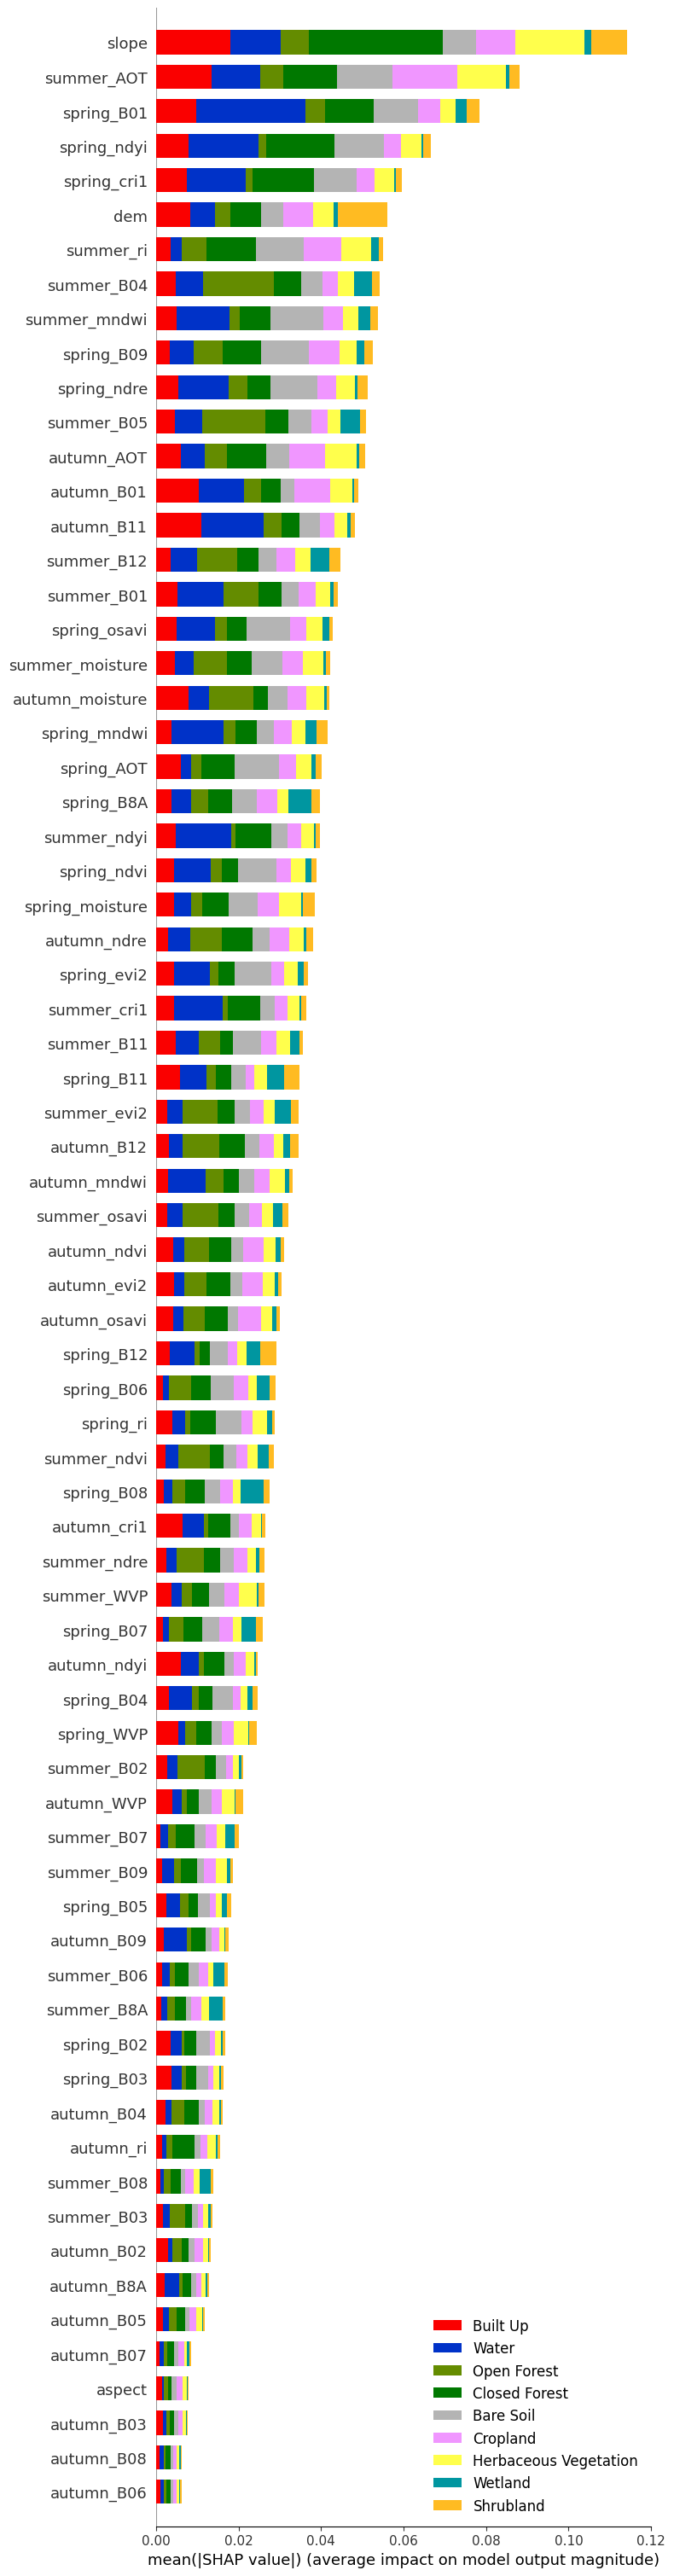

In [13]:
shap.summary_plot(shap_values, list(reduced_x_train_data.columns.values),  max_display =num_features, class_names=pretty_labels,  color= calculateColors, class_inds="original", show=False)
pl.savefig("all_features_DEF.png")


## Dividing the features in 2 

In this part we're going to divive the dataset in 2 halves. For this porpose the *train dataset* and the *shap_values* (the dimennsion corresponding to features) will be reduced to the halved 

In [14]:
half = int(np.round(num_features/2))

#### Crop the shap_values

In [15]:
shap_values_array = np.array(shap_values)
cropped_first_shap_values = list(shap_values_array[:,:,:half])
cropped_second_shap_values = list(shap_values_array[:,:,half:])

# alternatively, you can do directly -- > list_first_shap_values = [shap_values[i][:,:36] for i in range(len(shap_values))] 

#### Crop the train dataset

In [16]:
first_half_train= reduced_x_train_data.iloc[:,:half]

In [17]:
second_half_train= reduced_x_train_data.iloc[:,half:]

### Plot for the first half

For both plots, it's important to specicy **class_inds="original"** to set the labels in the correct order

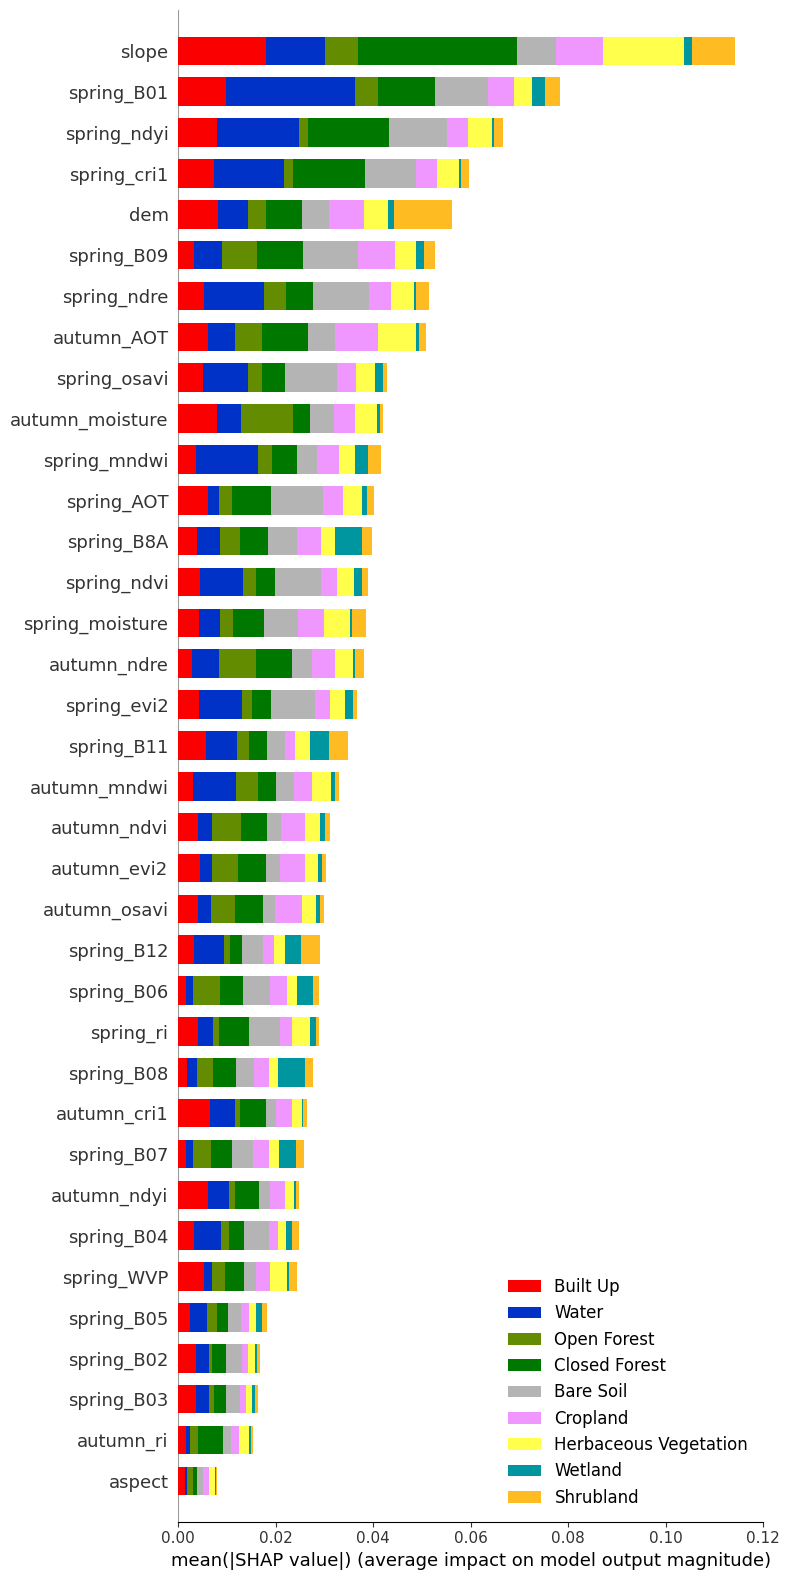

In [60]:
shap.summary_plot(cropped_first_shap_values,  first_half_train.columns.values, max_display = half, class_names=pretty_labels,  color= calculateColors, class_inds="original", show=False )
pl.xlim([0, 0.12])
pl.savefig("first_half_DEF.png")


### Plot for the second half

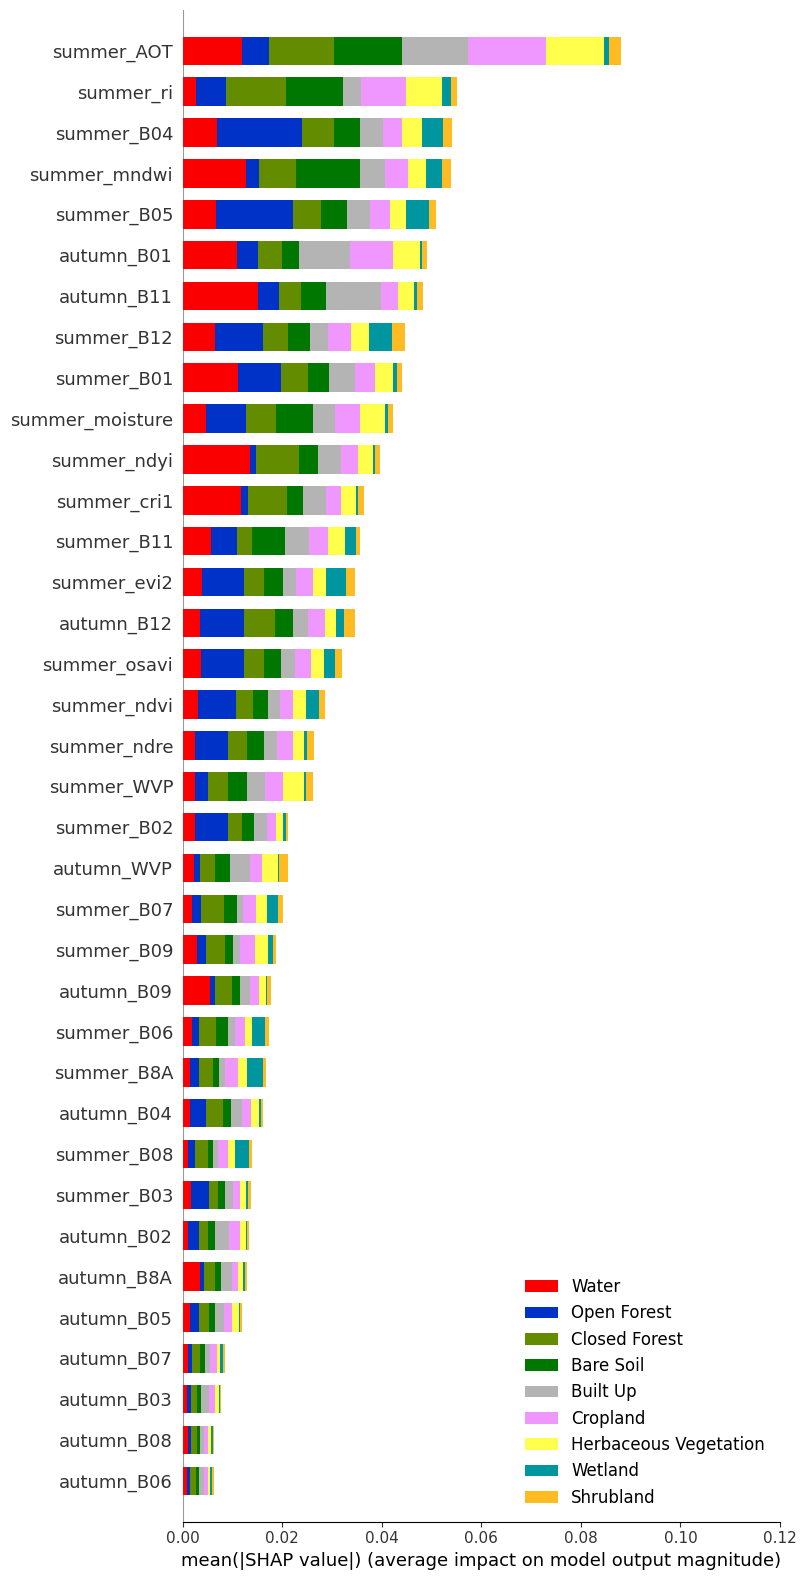

In [61]:
shap.summary_plot(cropped_second_shap_values,  second_half_train.columns.values, max_display = half, class_names=pretty_labels,  color= calculateColors, show=False )
pl.xlim([0, 0.12])
pl.savefig("second_half_DEF.png")


## Doing transpose - Discarded
Initially the form of **shap_values** is (classes, samples, features). You can do a transpose to change the dimensions of the matrix to get (features, samples, classes), however this does not make any sense because you cannot change the input to the model. (The model cannot have 9 classes as input and predict a feature).

In [20]:
np.shape(shap_values)

(9, 91, 72)

In [21]:
shap_values_transpose = np.transpose(shap_values, (2, 1, 0))

In [22]:
np.shape(shap_values_transpose)

(72, 91, 9)

In [40]:
np.shape(reduced_x_train_data.index.values)

(91,)

In [52]:
reduced_x_train_data.columns.values

array(['slope', 'aspect', 'dem', 'spring_cri1', 'spring_evi2',
       'spring_mndwi', 'spring_moisture', 'spring_ndre', 'spring_ndvi',
       'spring_ndyi', 'spring_osavi', 'spring_ri', 'spring_AOT',
       'spring_B01', 'spring_B02', 'spring_B03', 'spring_B04',
       'spring_B05', 'spring_B06', 'spring_B07', 'spring_B08',
       'spring_B09', 'spring_B11', 'spring_B12', 'spring_B8A',
       'spring_WVP', 'autumn_cri1', 'autumn_evi2', 'autumn_mndwi',
       'autumn_moisture', 'autumn_ndre', 'autumn_ndvi', 'autumn_ndyi',
       'autumn_osavi', 'autumn_ri', 'autumn_AOT', 'autumn_B01',
       'autumn_B02', 'autumn_B03', 'autumn_B04', 'autumn_B05',
       'autumn_B06', 'autumn_B07', 'autumn_B08', 'autumn_B09',
       'autumn_B11', 'autumn_B12', 'autumn_B8A', 'autumn_WVP',
       'summer_cri1', 'summer_evi2', 'summer_mndwi', 'summer_moisture',
       'summer_ndre', 'summer_ndvi', 'summer_ndyi', 'summer_osavi',
       'summer_ri', 'summer_AOT', 'summer_B01', 'summer_B02',
       'summer_B03

In [55]:
np.array(pretty_labels)

array(['Built Up', 'Water', 'Open Forest', 'Closed Forest', 'Bare Soil',
       'Cropland', 'Herbaceous Vegetation', 'Wetland', 'Shrubland'],
      dtype='<U21')

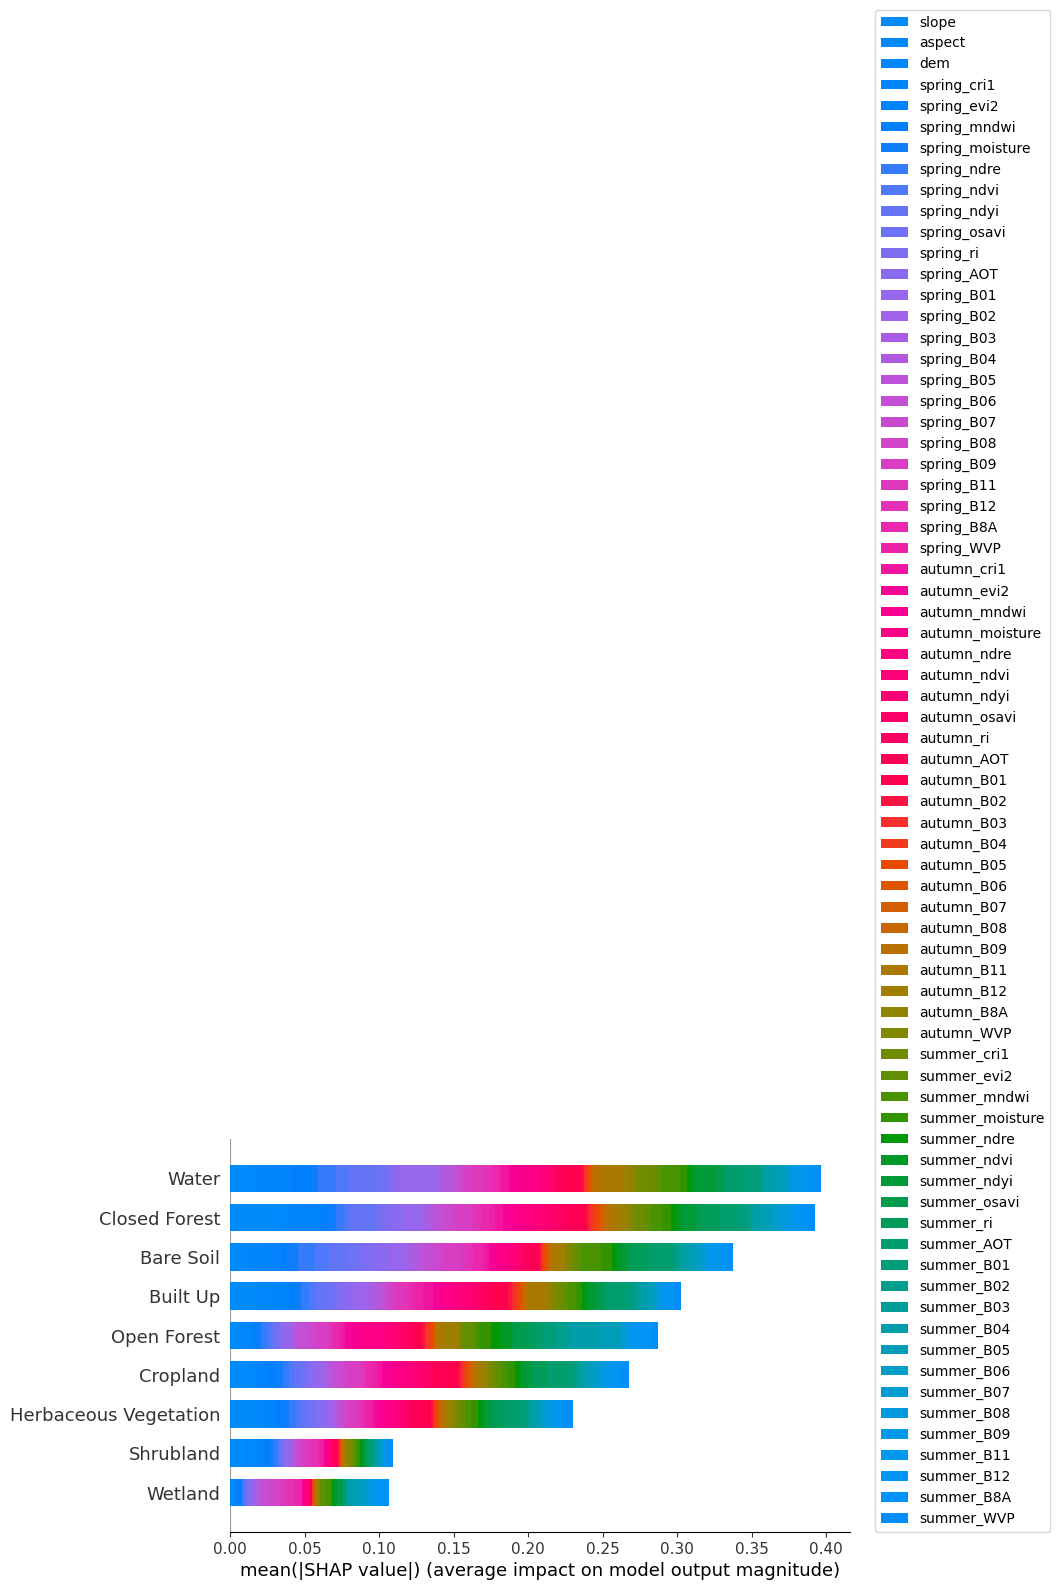

In [65]:

#shap.summary_plot(cropped_first_shap_values,  first_half_train.columns.values, max_display = half, class_names=pretty_labels,  color= calculateColors, class_inds="original", show=False )
shap.summary_plot(list(shap_values_transpose), np.array(pretty_labels), class_names=reduced_x_train_data.columns.values,  max_display = 9,class_inds="original",  show=False )
pl.legend(loc=(1.04, 0))
pl.savefig("transpose_plot_DEF1.png", bbox_inches = 'tight')
pl.tight_layout()


### Split by class

In [ ]:
def data_train(data, pc_columns):
    y_train_data = data["class"] 
    x_train_data = data.drop(["class", "latitude", "longitude", "spring_product_name", "autumn_product_name", "summer_product_name"], axis=1)

    reduced_x_train_data = data[pc_columns]
    #reduced_x_train_data.to_csv(f'{label}.csv')

    X_train, X_test, y_train, y_test = train_test_split(reduced_x_train_data, y_train_data, test_size=0.50, random_state=0,)

    y_true = model.predict(X_test)

    X_train = pd.DataFrame(X_train).reset_index(drop=True, inplace=False)
    X_test = pd.DataFrame(X_test).reset_index(drop=True, inplace=False)
    y_test = pd.DataFrame(y_test).reset_index(drop=True, inplace=False)
    y_train = pd.DataFrame(y_train).reset_index(drop=True, inplace=False)
    y_true = pd.DataFrame(y_true).reset_index(drop=True, inplace=False)
    

    return X_train, X_test, y_train, y_test, y_true


In [ ]:
labels = ['closedForest']
print(labels)

In [ ]:
for label in labels:
    b_aux = data['class'] == label
    b = data[b_aux]
    print(b)
    X_train, X_test, y_train, y_test, y_true = data_train(b, pc_columns)
    print("sssssssssssssssss",X_train)
    explainer = shap.TreeExplainer(model)
    choosen_instance = X_test.loc[0:10]
    shap_values = explainer.shap_values(choosen_instance)
    shap.initjs()
    shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)


In [ ]:
explainer = shap.TreeExplainer(model)
choosen_instance = X_test.loc[0:3]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)